# Designing and training autoencoders using Python

In this notebook, we illustrate how to implement several of the autoencoder models introduced in the preceding section using Keras. We first load and prepare an image dataset that we use throughout this section because it makes it easier to visualize the results of the encoding process.

We then proceed to build autoencoders using deep feedforward nets, sparsity constraints, and convolutions and then apply the latter to denoise images.

Source: https://blog.keras.io/building-autoencoders-in-keras.html

## Imports & Settings

In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd

import numpy as np
from numpy.random import choice
from numpy.linalg import norm
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.axes_grid1 import make_axes_locatable

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist

from sklearn.preprocessing import minmax_scale

from scipy.spatial.distance import pdist, cdist

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
sns.set_style('whitegrid')

In [4]:
n_classes = 10 # all examples have 10 classes
cmap = sns.color_palette('Paired', n_classes)

In [5]:
results_path = Path('results', 'fashion_mnist')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Fashion MNIST Data

For illustration, we'll use the Fashion MNIST dataset, a modern drop-in replacement for the classic MNIST handwritten digit dataset popularized by Yann LeCun with LeNet in the 1990s. We also relied on this dataset in Chapter 12, Unsupervised Learning.

In [6]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

Keras makes it easy to access the 60,000 train and 10,000 test grayscale samples with a resolution of 28 x 28 pixels:

In [7]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [8]:
image_size = 28     # size of image (pixels per side)
input_size = image_size ** 2 # Compression factor: 784 / 32 = 24.5

In [9]:
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}
classes = list(class_dict.keys())

### Plot sample images

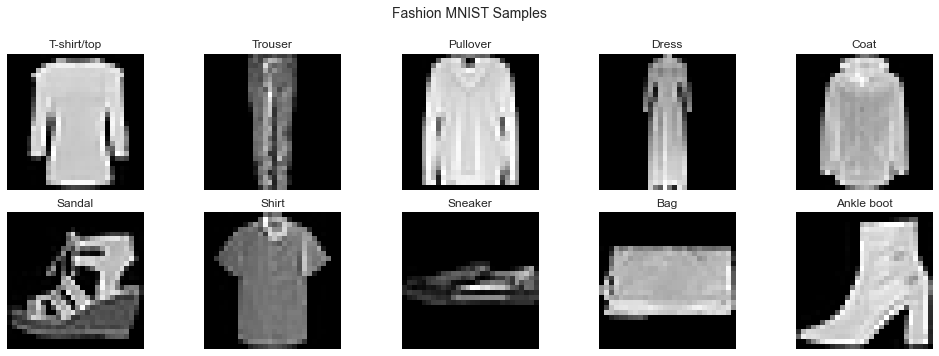

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 5))
axes =axes.flatten()
for row, label in enumerate(classes):
    label_idx = np.argwhere(y_train == label).squeeze()
    axes[row].imshow(X_train[choice(label_idx)], cmap='gray')
    axes[row].axis('off')
    axes[row].set_title(class_dict[row])

fig.suptitle('Fashion MNIST Samples', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85)

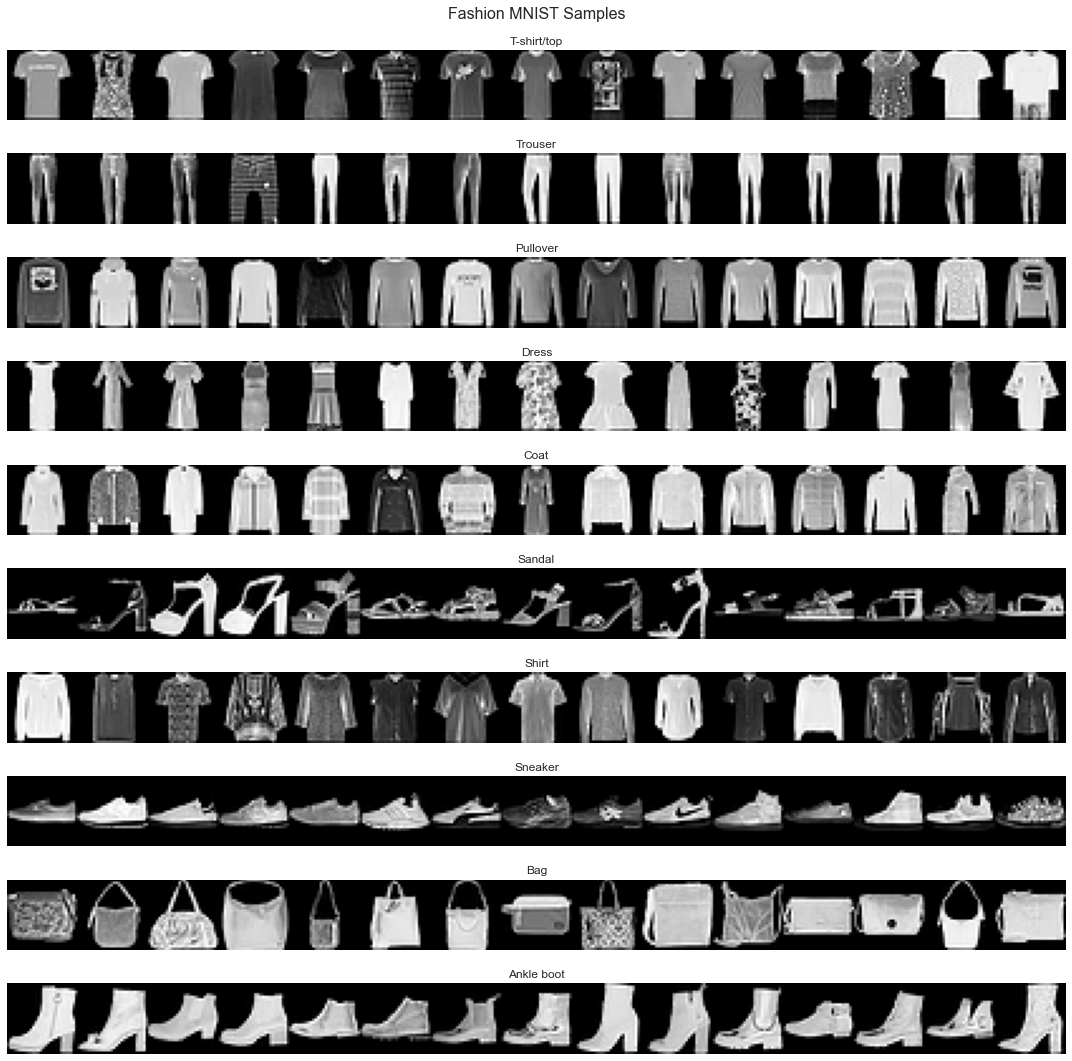

In [11]:
n_samples = 15
fig, axes = plt.subplots(nrows=n_classes, figsize=(15, 15))
axes =axes.flatten()
for row, label in enumerate(classes):
    class_imgs = np.empty(shape=(image_size, n_samples * image_size))
    label_idx = np.argwhere(y_train == label).squeeze()
    class_samples = choice(label_idx, size=n_samples, replace=False)
    for col, sample in enumerate(class_samples):
        i = col * image_size
        class_imgs[:, i:i + image_size] = X_train[sample]
    axes[row].imshow(class_imgs, cmap='gray')
    axes[row].axis('off')
    axes[row].set_title(class_dict[row])

fig.suptitle('Fashion MNIST Samples', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=.95, bottom=0)

## Reshape & normalize Fashion MNIST data

We reshape the data so that each image is represented by a flat one-dimensional pixel vector with 28 x 28 = 784 elements normalized to the range of [0, 1]:

In [12]:
encoding_size = 32 # Size of encoding

In [13]:
def data_prep(x, size=input_size):
    return x.reshape(-1, size).astype('float32')/255

In [14]:
X_train_scaled = data_prep(X_train)
X_test_scaled = data_prep(X_test)

In [15]:
X_train_scaled.shape, X_test_scaled.shape

((60000, 784), (10000, 784))

## Vanilla single-layer autoencoder

We start with a vanilla feedforward autoencoder with a single hidden layer to illustrate the general design approach using the functional Keras API and establish a performance baseline.

Encoding 28 x 28 images to a 32 value representation for a compression factor of 24.5

### Single-layer Model

#### Input Layer

In [16]:
input_ = Input(shape=(input_size,), name='Input')

#### Dense Encoding Layer

The encoder part of the model consists of a fully-connected layer that learns the new, compressed representation of the input. We use 32 units for a compression ratio of 24.5:

In [17]:
encoding = Dense(units=encoding_size,
                 activation='relu',
                 name='Encoder')(input_)

#### Dense Reconstruction Layer

The decoding part reconstructs the compressed data to its original size in a single step:

In [18]:
decoding = Dense(units=input_size,
                 activation='sigmoid',
                 name='Decoder')(encoding)

#### Autoencoder Model

In [19]:
autoencoder = Model(inputs=input_,
                    outputs=decoding,
                    name='Autoencoder') 

The thus defined encoder-decoder computation uses almost 51,000 parameters:

In [20]:
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
Decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


### Encoder Model

The functional API allows us to use parts of the model's chain as separate encoder and decoder models that use the autoencoder's parameters learned during training.

The encoder just uses the input and hidden layer with about half of the total parameters:

In [21]:
encoder = Model(inputs=input_ ,
                outputs=encoding,
                name='Encoder')

In [22]:
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder (Dense)              (None, 32)                25120     
Total params: 25,120
Trainable params: 25,120
Non-trainable params: 0
_________________________________________________________________


Once we train the autoencoder, we can use the encoder to compress the data.

### Decoder Model

The decoder consists of the last autoencoder layer, fed by a placeholder for the encoded data:

#### Placeholder for encoded input

In [23]:
encoded_input = Input(shape=(encoding_size,),
                      name='Decoder_Input')

#### Extract last autoencoder layer

In [24]:
decoder_layer = autoencoder.layers[-1](encoded_input)

#### Define Decoder Model

In [25]:
decoder = Model(inputs=encoded_input,
                outputs=decoder_layer)

In [26]:
decoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
Decoder (Dense)              (None, 784)               25872     
Total params: 25,872
Trainable params: 25,872
Non-trainable params: 0
_________________________________________________________________


### Compile the Autoencoder Model

In [27]:
autoencoder.compile(optimizer='adam', 
                    loss='mse')

### Train the autoencoder

We compile the model to use the Adam optimizer (see Chapter 17, Deep Learning) to minimize the MSE between the input data and the reproduction achieved by the autoencoder. To ensure that the autoencoder learns to reproduce the input, we train the model using the same input and output data:

#### Create `early_stopping` callback

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               min_delta=1e-5, 
                               patience=5, 
                               verbose=0,
                               restore_best_weights=True,
                               mode='auto')

#### Create TensorBard callback to visualize network performance

In [29]:
tb_callback = TensorBoard(log_dir=results_path / 'logs',
                          histogram_freq=5,
                          write_graph=True,
                          write_images=True)

#### Create checkpoint callback

In [30]:
filepath = (results_path / 'autencoder.32.weights.hdf5').as_posix()

In [31]:
checkpointer = ModelCheckpoint(filepath=filepath, 
                               monitor='val_loss', 
                               save_best_only=True,
                               save_weights_only=True,
                               mode='auto')

#### Fit the Model 

To avoid running time, you can load the pre-computed results in the 'model' folder (see below)

In [32]:
training = autoencoder.fit(x=X_train_scaled,
                           y=X_train_scaled,
                           epochs=100,
                           batch_size=32,
                           shuffle=True,
                           validation_split=.1,
                           callbacks=[tb_callback, early_stopping, checkpointer])

Epoch 1/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0300 - val_loss: 0.0180
Epoch 2/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0157 - val_loss: 0.0147
Epoch 3/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0139 - val_loss: 0.0136
Epoch 4/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0133 - val_loss: 0.0132
Epoch 5/100
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0130 - val_loss: 0.0130
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0129 - val_loss: 0.0130
Epoch 7/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0128 - val_loss: 0.0128
Epoch 8/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0127 - val_loss: 0.0128
Epoch 9/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0127 - val_loss: 0.0127
Epoch 10/100
1688/1688 [==============================] - 4s 2ms/step - l

### Reload weights from best-performing model

In [33]:
autoencoder.load_weights(filepath)

### Evaluate trained model 

Training stops after some 20 epochs with a test RMSE of 0.1122:

In [34]:
mse = autoencoder.evaluate(x=X_test_scaled, y=X_test_scaled)
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

313/313 [==============================] - 0s 1ms/step - loss: 0.0125


'MSE: 0.0125 | RMSE 0.1120'

### Encode and decode test images

To encode data, we use the encoder we just defined, like so:

In [35]:
encoded_test_img = encoder.predict(X_test_scaled)
encoded_test_img.shape

(10000, 32)

The decoder takes the compressed data and reproduces the output according to the autoencoder training results:

In [36]:
decoded_test_img = decoder.predict(encoded_test_img)
decoded_test_img.shape

(10000, 784)

#### Compare Original with Reconstructed Samples 

The following figure shows ten original images and their reconstruction by the autoencoder and illustrates the loss after compression:

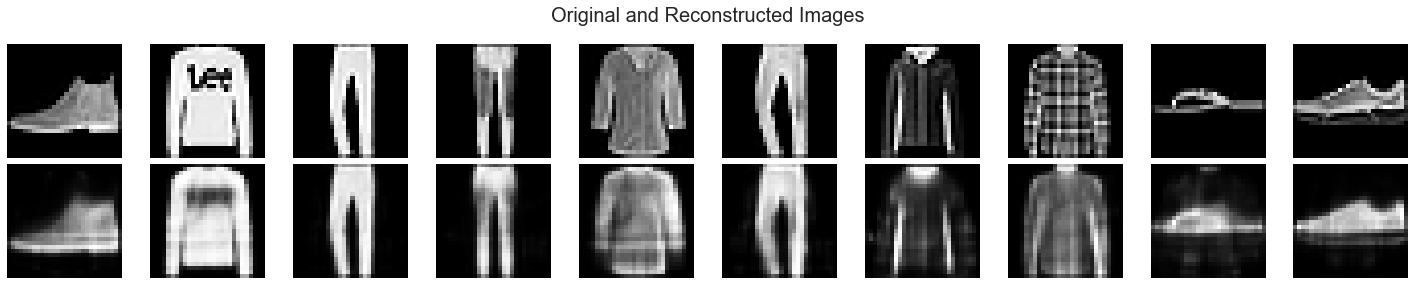

In [37]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):
    
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(decoded_test_img[i].reshape(28, 28) , cmap='gray')
    axes[1, i].axis('off')

fig.suptitle('Original and Reconstructed Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.85)
fig.savefig(results_path / 'reconstructed', dpi=300)

## Combine training steps into function

The helper function `train_autoencoder` just summarizes some repetitive steps.

In [38]:
def train_autoencoder(path, model, x_train=X_train_scaled, x_test=X_test_scaled):
    callbacks = [EarlyStopping(patience=5,
                               restore_best_weights=True),
                 ModelCheckpoint(filepath=path,
                                 save_best_only=True,
                                 save_weights_only=True)]
    model.fit(x=x_train,
              y=x_train,
              epochs=100,
              validation_split=.1,
              callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test)
    return model, mse

## Autoencoders with Sparsity Constraints

### Encoding Layer with L1 activity regularizer

The addition of regularization is fairly straightforward. We can apply it to the dense encoder layer using Keras' `activity_regularizer`, as follows:

In [39]:
encoding_l1 = Dense(units=encoding_size,
                    activation='relu',
                    activity_regularizer=regularizers.l1(10e-5),
                    name='Encoder_L1')(input_)

### Decoding Layer

In [40]:
decoding_l1 = Dense(units=input_size,
                    activation='sigmoid',
                    name='Decoder_L1')(encoding_l1)

In [41]:
autoencoder_l1 = Model(input_, decoding_l1)

### Autoencoder Model

In [42]:
autoencoder_l1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
Encoder_L1 (Dense)           (None, 32)                25120     
_________________________________________________________________
Decoder_L1 (Dense)           (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [43]:
autoencoder_l1.compile(optimizer='adam', 
                       loss='mse')

### Encoder & Decoder Models

In [44]:
encoder_l1 = Model(inputs=input_, outputs=encoding_l1, name='Encoder')

In [45]:
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')
decoder_l1_layer = autoencoder_l1.layers[-1](encoded_input)
decoder_l1 = Model(inputs=encoded_input, outputs=decoder_l1_layer)

### Train Model

In [46]:
path = (results_path / 'autencoder_l1.32.weights.hdf5').as_posix()
autoencoder_l1, mse = train_autoencoder(path, autoencoder_l1)

Epoch 1/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0338 - val_loss: 0.0215
Epoch 2/100
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0195 - val_loss: 0.0185
Epoch 3/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0176 - val_loss: 0.0174
Epoch 4/100
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0168 - val_loss: 0.0166
Epoch 5/100
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0163 - val_loss: 0.0166
Epoch 6/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0160 - val_loss: 0.0160
Epoch 7/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0157 - val_loss: 0.0160
Epoch 8/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0155 - val_loss: 0.0155
Epoch 9/100
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0154 - val_loss: 0.0156
Epoch 10/100
1688/1688 [==============================] - 5s 3ms/step - l

### Evaluate Model

The input and decoding layers remain unchanged. In this example, with a compression of factor 24.5, regularization negatively affects performance with a test RMSE of 0.0.1229.

In [47]:
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

'MSE: 0.0143 | RMSE 0.1196'

In [48]:
encoded_test_img = encoder_l1.predict(X_test_scaled)

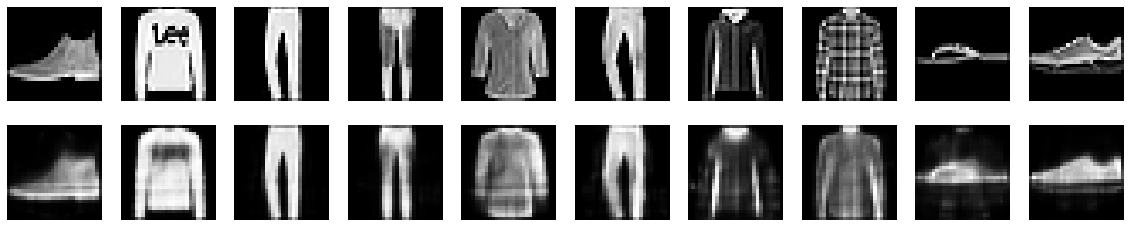

In [49]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):

    axes[0, i].imshow(X_test_scaled[i].reshape(image_size,
                                               image_size),
                      cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(decoded_test_img[i].reshape(28, 28),
                      cmap='gray')
    axes[1, i].axis('off')

##  Deep Autoencoder

To illustrate the benefit of adding depth to the autoencoder, we build a three-layer feedforward model that successively compresses the input from 784 to 128, 64, and 34 units, respectively:

### Define three-layer architecture

In [50]:
input_ = Input(shape=(input_size,))
x = Dense(128, activation='relu', name='Encoding1')(input_)
x = Dense(64, activation='relu', name='Encoding2')(x)
encoding_deep = Dense(32, activation='relu', name='Encoding3')(x)

x = Dense(64, activation='relu', name='Decoding1')(encoding_deep)
x = Dense(128, activation='relu', name='Decoding2')(x)
decoding_deep = Dense(input_size, activation='sigmoid', name='Decoding3')(x)

In [51]:
autoencoder_deep = Model(input_, decoding_deep)
autoencoder_deep.compile(optimizer='adam', loss='mse')

The resulting model has over 222,000 parameters, more than four times the capacity of the preceding single-layer model:

In [52]:
autoencoder_deep.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
Encoding1 (Dense)            (None, 128)               100480    
_________________________________________________________________
Encoding2 (Dense)            (None, 64)                8256      
_________________________________________________________________
Encoding3 (Dense)            (None, 32)                2080      
_________________________________________________________________
Decoding1 (Dense)            (None, 64)                2112      
_________________________________________________________________
Decoding2 (Dense)            (None, 128)               8320      
_________________________________________________________________
Decoding3 (Dense)            (None, 784)               1011

### Encoder & Decoder Models

In [53]:
encoder_deep = Model(inputs=input_, outputs=encoding_deep, name='Encoder')

In [54]:
encoded_input = Input(shape=(encoding_size,), name='Decoder_Input')

x = autoencoder_deep.layers[-3](encoded_input)
x = autoencoder_deep.layers[-2](x)
decoded = autoencoder_deep.layers[-1](x)

decoder_deep = Model(inputs=encoded_input, outputs=decoded)

In [55]:
decoder_deep.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Decoder_Input (InputLayer)   [(None, 32)]              0         
_________________________________________________________________
Decoding1 (Dense)            (None, 64)                2112      
_________________________________________________________________
Decoding2 (Dense)            (None, 128)               8320      
_________________________________________________________________
Decoding3 (Dense)            (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [56]:
path = (results_path  / 'autencoder_deep.32.weights.hdf5').as_posix()

In [57]:
autoencoder_deep, mse = train_autoencoder(path, autoencoder_deep)

Epoch 1/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0260 - val_loss: 0.0180
Epoch 2/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0166 - val_loss: 0.0156
Epoch 3/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 4/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 5/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0130 - val_loss: 0.0129
Epoch 6/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0125 - val_loss: 0.0124
Epoch 7/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0121 - val_loss: 0.0123
Epoch 8/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0117 - val_loss: 0.0118
Epoch 9/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0115 - val_loss: 0.0120
Epoch 10/100
1688/1688 [==============================] - 7s 4ms/step - l

In [58]:
autoencoder_deep.load_weights(path)

### Evaluate Model

Training stops after 54 epochs and results in a ~10% reduction of the test RMSE to 0.1026. Due to the low resolution, it is difficult to visually note the better reconstruction.

In [59]:
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

'MSE: 0.0094 | RMSE 0.0968'

In [60]:
reconstructed_images = autoencoder_deep.predict(X_test_scaled)
reconstructed_images.shape

(10000, 784)

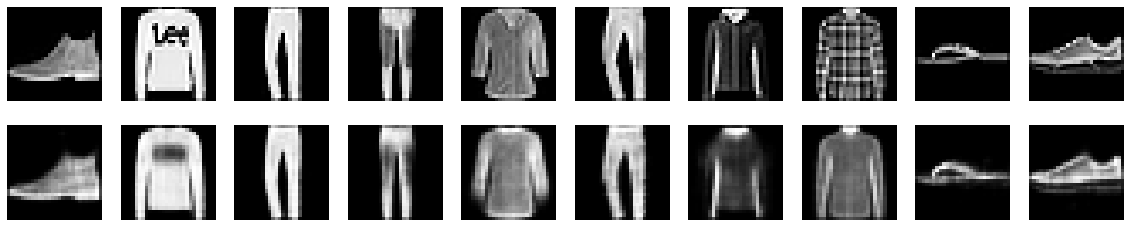

In [61]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):
    
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[1, i].axis('off')

### Compute t-SNE Embedding

We can use the t-distributed Stochastic Neighbor Embedding (t-SNE) manifold learning technique, see Chapter 12, Unsupervised Learning, to visualize and assess the quality of the encoding learned by the autoencoder's hidden layer.

If the encoding is successful in capturing the salient features of the data, the compressed representation of the data should still reveal a structure aligned with the 10 classes that differentiate the observations.

We use the output of the deep encoder we just trained to obtain the 32-dimensional representation of the test set:

Since t-SNE can take a long time to run, we are providing pre-computed results

In [62]:
# alternatively, compute the result yourself
# tsne = TSNE(perplexity=25, n_iter=5000)
# train_embed = tsne.fit_transform(encoder_deep.predict(X_train_scaled))

#### Persist result

In [63]:
# store results given computational intensity (different location to avoid overwriting the pre-computed results)
# pd.DataFrame(train_embed).to_hdf('tsne.h5', 'autoencoder_deep')

#### Load pre-computed embeddings

In [64]:
# Load the pre-computed results here:
train_embed = pd.read_hdf(results_path / 'tsne.h5', 'autoencoder_deep')

#### Visualize Embedding

In [65]:
def plot_embedding(X, y=y_train, title=None, min_dist=0.1, n_classes=10, cmap=cmap):
    X = minmax_scale(X)
    inner = outer = 0
    for c in range(n_classes):
        inner += np.mean(pdist(X[y == c]))
        outer += np.mean(cdist(X[y == c], X[y != c]))
    fig, ax = plt.subplots(figsize=(14, 10))
    ax.axis('off')
    ax.set_title(title + ' | Distance: {:.2%}'.format(inner/outer))
    sc = ax.scatter(*X.T, c=y, cmap=ListedColormap(cmap), s=5)
    shown_images = np.ones((1, 2))
    images = X_train.reshape(-1, 28, 28)
    for i in range(0, X.shape[0]):
        dist = norm(X[i] - shown_images, axis=1)
        if (dist > min_dist).all():
            shown_images = np.r_[shown_images, [X[i]]]
            imagebox = AnnotationBbox(OffsetImage(images[i],
                                                  cmap=plt.cm.gray_r),
                                      X[i])
            ax.add_artist(imagebox)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    plt.colorbar(sc, cax=cax)
    fig.tight_layout()
    fig.savefig(results_path / 'tsne_autoencoder_deep', dpi=300)

The following figure shows that t-SNE manages to separate the 10 classes well, suggesting that the encoding is useful as a lower-dimensional representation that preserves key characteristics of the data:

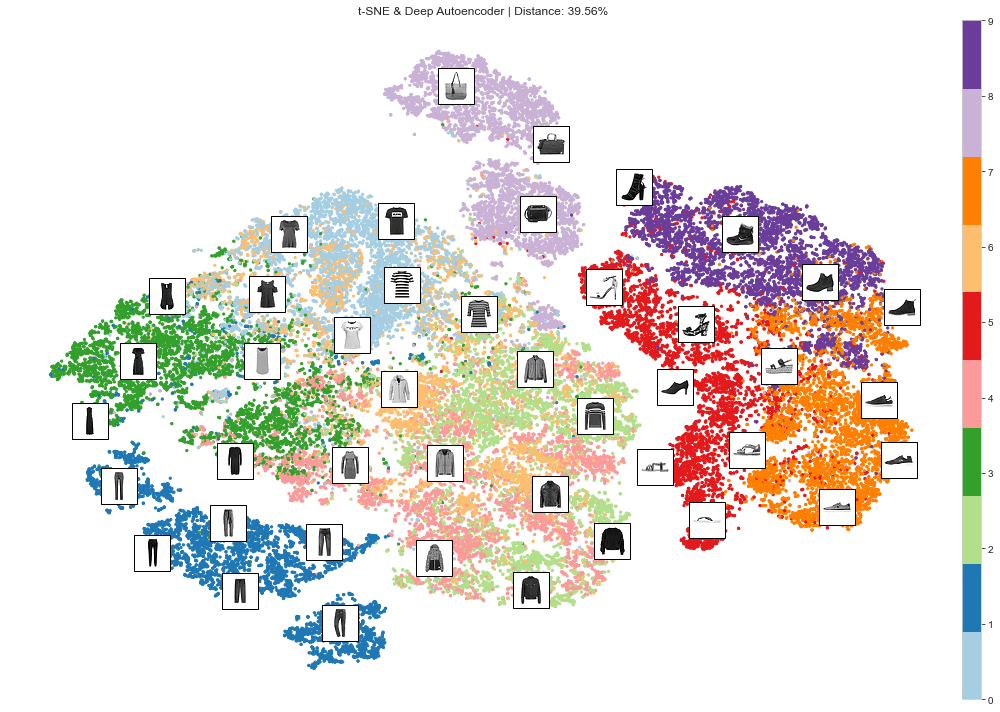

In [66]:
plot_embedding(X=train_embed, title='t-SNE & Deep Autoencoder')